Suggested by DLM as a potential slow degree of freedom that may not be sampled easily.

Approach 
1. Identify all molecules that contain a carboxyl group
2. For each such molecule, identify all the torsion angles that involve a hydroxyl hydrogen
3. Plot and see -- would expect there to be two modes separated by 180 degrees, sampled at least a little bit -- what's the relaxation time for this flip?
4. If this suggests any test that can be automated, put it in `bayes_implicit_solvent.utils` or something

In [22]:
from openeye import oechem
from bayes_implicit_solvent.solvation_free_energy import smiles_list, db, mol_top_sys_pos_list
import mdtraj as md
import pyemma
from simtk import unit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

t = np.arange(10000) * 1000 * unit.femtosecond / unit.nanosecond

In [34]:
#hydroxyl_in_carboxylic_acid_smarts = '[OX2H][CX3]=[OX1]' # had zero hits!
#carboxyl_smarts = '[CX3](=O)[OX2H1]' # had zero hits!
#carboxyl_smarts = '[CX3](=O)[OX1H0-,OX2H1]' # has >0 hits, but misses acetic acid...
#hydroxyl_smarts = '[OX2H]' # hits a lot of extra things, obviously

carbonyl_O_smarts = '[CX3](=[OX1])O'

In [35]:
def get_target_atom_names_that_match_smarts(mol, smarts):
    mol_ = oechem.OEMol(mol)
    qmol = oechem.OEQMol()
    oechem.OEParseSmarts(qmol, smarts)

    unique = False
    ss = oechem.OESubSearch(qmol)
    matches = []
    for match in ss.Match( mol_, unique):
        matches.append(set([a.GetName() for a in match.GetTargetAtoms()]))
    return matches

In [36]:
all_matches = []
for i in range(len(mol_top_sys_pos_list)):
    mol, _, _, _ = mol_top_sys_pos_list[i]
    #all_matches.append(get_target_atom_names_that_match_smarts(mol, carboxyl_smarts))
    #all_matches.append(get_target_atom_names_that_match_smarts(mol, hydroxyl_smarts))
    #all_matches.append(get_target_atom_names_that_match_smarts(mol, hydroxyl_in_carboxylic_acid_smarts))
    all_matches.append(get_target_atom_names_that_match_smarts(mol, carbonyl_O_smarts))

In [37]:
problematic_inds = [i for i in range(len(all_matches)) if len(all_matches[i]) > 0]

In [46]:
all_matches[problematic_inds[0]]

[{'C14', 'O2', 'O3'}]

# TODO: BETTER ALGORITHM FOR ENUMERATING TORSIONS

In [38]:
[(i, smiles_list[i]) for i in problematic_inds]

[(25, 'C[C@@H](c1cccc(c1)C(=O)c2ccccc2)C(=O)O'),
 (29, 'C[C@@H](c1ccc(c(c1)F)c2ccccc2)C(=O)O'),
 (32, 'CCOC(=O)C[C@H](C(=O)OCC)SP(=S)(OC)OC'),
 (45, 'C[C@@H](c1ccc2cc(ccc2c1)OC)C(=O)O'),
 (54, 'C[C@@H](c1ccc(cc1)CC(C)C)C(=O)O'),
 (57, 'c1cc(c(cc1c2ccc(cc2F)F)C(=O)O)O'),
 (63, 'Cc1c(nc(nc1OC(=O)N(C)C)N(C)C)C'),
 (64, 'COC(=O)c1ccc(cc1)[N+](=O)[O-]'),
 (71, 'CC(=CCC[C@](C)(C=C)OC(=O)C)C'),
 (80, 'Cc1cccc(c1C)Nc2ccccc2C(=O)O'),
 (82, 'CC1(Cc2cccc(c2O1)OC(=O)NC)C'),
 (92, 'CC(=O)OCC(COC(=O)C)OC(=O)C'),
 (105, 'COc1c(ccc(c1C(=O)O)Cl)Cl'),
 (116, 'CC(C)(/C=N\\OC(=O)NC)SC'),
 (122, 'CNC(=O)Oc1cccc2c1cccc2'),
 (127, 'CC(=O)Oc1ccccc1C(=O)O'),
 (135, 'CCCCOC(=O)c1ccc(cc1)O'),
 (148, 'CCCOC(=O)c1ccc(cc1)O'),
 (150, 'COc1ccc(cc1)C(=O)OC'),
 (154, 'CCOC(=O)c1ccc(cc1)O'),
 (160, 'CCOC(=O)CCC(=O)OCC'),
 (164, 'CC(OC(=O)C)OC(=O)C'),
 (172, 'COC(=O)c1ccc(cc1)O'),
 (185, 'CCOC(=O)CC(=O)OCC'),
 (189, 'CC(C)COC(=O)C(C)C'),
 (213, 'CC(=O)OCCOC(=O)C'),
 (215, 'CCOC(=O)c1ccccc1'),
 (221, 'COC(=O)C(F)(F)F'),


In [39]:
def bonds_share_an_atom(bond1, bond2):
    return bond1[1] == bond2[0]

def get_torsion_tuples(traj):
    """dumb brute-force O(n_bonds^3) iteration"""
    
    bonds = list([(a.index, b.index) for (a,b) in traj.top.bonds]) + list([(b.index, a.index) for (a,b) in traj.top.bonds])
    torsions = []
    for bond1 in bonds:
        for bond2 in bonds:
            for bond3 in bonds:
                if bonds_share_an_atom(bond1, bond2) and bonds_share_an_atom(bond2, bond3):
                    putative_torsion = (bond1[0], bond1[1], bond2[1], bond3[1])
                    if putative_torsion[-1] < putative_torsion[0]:
                        putative_torsion = putative_torsion[::-1]
                    if len(set(putative_torsion)) == 4:
                        torsions.append(putative_torsion)
    return sorted(list(set(torsions)))

In [40]:
freesolv_dict = {}
for i in range(len(db)):
    smiles = db[i][1]
    freesolv_dict[smiles] = db[i]

total # torsions:  77
# selected torsions:  0
total # torsions:  73
# selected torsions:  0
total # torsions:  67
# selected torsions:  0
total # torsions:  70
# selected torsions:  0
total # torsions:  78
# selected torsions:  0
total # torsions:  58
# selected torsions:  2
total # torsions:  64
# selected torsions:  0
total # torsions:  37
# selected torsions:  0
total # torsions:  70
# selected torsions:  0
total # torsions:  72
# selected torsions:  0
total # torsions:  76
# selected torsions:  0
total # torsions:  51
# selected torsions:  0
total # torsions:  33
# selected torsions:  0
total # torsions:  45
# selected torsions:  0
total # torsions:  58
# selected torsions:  0
total # torsions:  38
# selected torsions:  0
total # torsions:  62
# selected torsions:  2
total # torsions:  53
# selected torsions:  2
total # torsions:  38
# selected torsions:  0
total # torsions:  44
# selected torsions:  2
total # torsions:  49
# selected torsions:  0
total # torsions:  31
# selected t

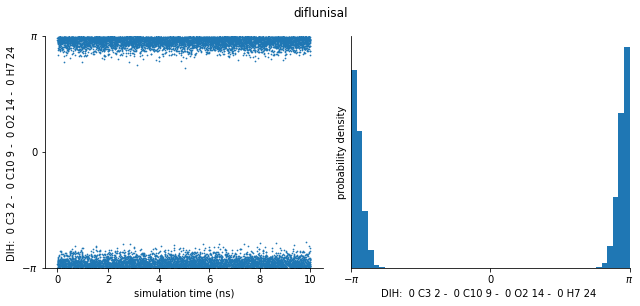

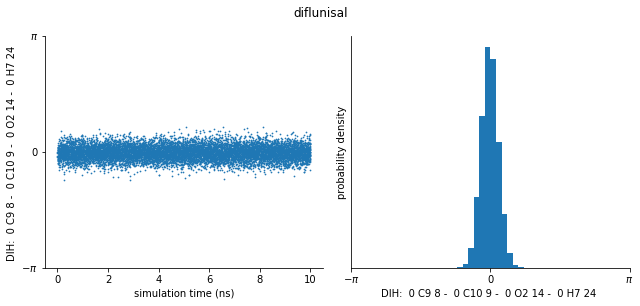

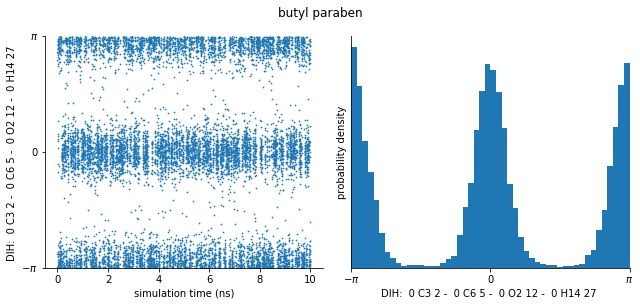

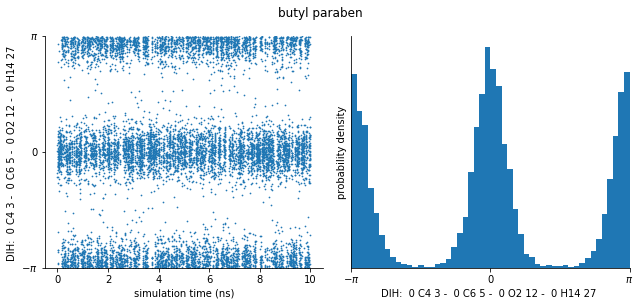

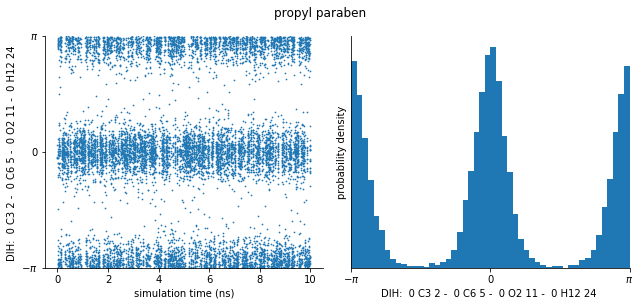

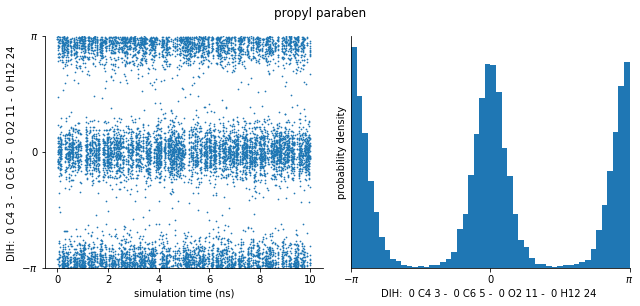

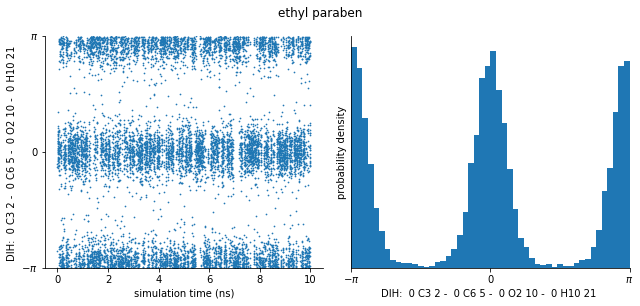

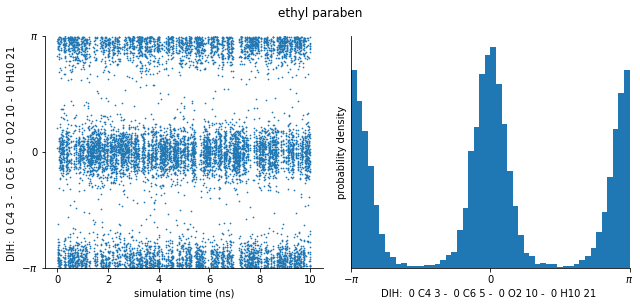

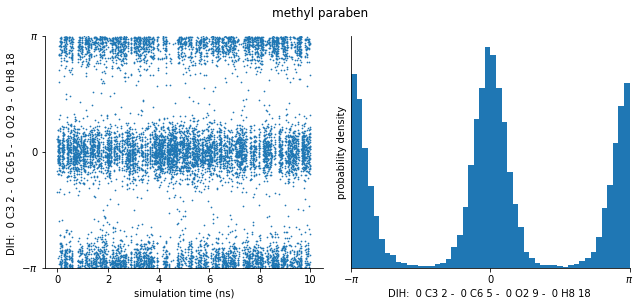

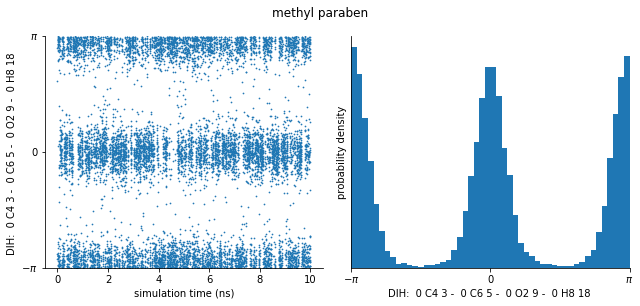

In [45]:
# loop over the flagged molecules and loop over the desired torsions, make plots
for ind in problematic_inds:
    smiles = smiles_list[ind]
    freesolv_entry = freesolv_dict[smiles]
    freesolv_id, chemical_name = freesolv_entry[0], freesolv_entry[2]
    title = chemical_name
    
    traj_name = '../bayes_implicit_solvent/vacuum_samples/vacuum_samples_{}.h5'.format(ind)
    traj = md.load(traj_name)
    torsions = get_torsion_tuples(traj)
    
    print('total # torsions: ', len(torsions))
    
    atom_names = [a.name for a in traj.top.atoms]
    element_symbols = [a.element.symbol for a in traj.top.atoms]
    
    selected_torsions = []
    
    atoms_of_interest = set()
    for match_atom_name_set in all_matches[ind]:
        atoms_of_interest = atoms_of_interest.union(match_atom_name_set)
    
    for torsion in torsions:
        torsion_atom_name_set = set([atom_names[atom_ind] for atom_ind in torsion])
        torsion_element_list = [element_symbols[atom_ind] for atom_ind in torsion]
        torsion_element_string = ''.join(torsion_element_list)
        
        contains_OH = ('OH' in torsion_element_string) or ('HO' in torsion_element_string)
        contains_only_one_H = (sum([e == 'H' for e in torsion_element_list]) == 1)
        contains_atoms_of_interest = len(atoms_of_interest.intersection(torsion_atom_name_set)) > 0
        
        #if contains_OH and contains_only_one_H and contains_atoms_of_interest:
        #if contains_OH and contains_only_one_H:
        #if contains_OH:
        #if contains_atoms_of_interest:
            selected_torsions.append(torsion)
    
    print('# selected torsions: ', len(selected_torsions))
    
    if len(selected_torsions) > 0:
    
        feat = pyemma.coordinates.featurizer(traj.topology)
        feat.add_dihedrals(selected_torsions, cossin=False)
        X = feat.transform(traj)

        for j in range(len(feat.describe())):

            angle_name = feat.describe()[j]

            fig = plt.figure(figsize=(9,4))
            ax = plt.subplot(1,2,1)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            plt.scatter(t, X[:,j], s=0.5)

            plt.xlabel('simulation time (ns)')

            plt.ylim(-np.pi, np.pi)
            plt.ylabel(angle_name)
            plt.yticks((-np.pi, 0, np.pi), (r'$-\pi$', '0', r'$\pi$'))

            ax = plt.subplot(1,2,2)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            plt.hist(X[:,j], bins=50, range=(-np.pi, np.pi))

            plt.xlim(-np.pi, np.pi)
            plt.xlabel(angle_name)
            plt.xticks((-np.pi, 0, np.pi), (r'$-\pi$', '0', r'$\pi$'))

            plt.yticks([])
            plt.ylabel('probability density')


            fig.suptitle(title, y=1.05)
            plt.tight_layout()

            plt.savefig('carboxyl-torsion-plots/{}_torsion{}.png'.format(freesolv_id, j), dpi=300, bbox_inches='tight')